#### Import required libraries

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
from sklearn.cluster import KMeans

#### Import the dataset for NYC crimes in 2017 

In [55]:
crime_df = pd.read_csv("NY_crime.csv")
crime_df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,736216184,09/30/2016,23:25:00,09/30/2016,23:25:00,09/30/2016,236,DANGEROUS WEAPONS,782.0,"WEAPONS, POSSESSION, ETC",...,42.0,NaN,TRANSIT - NYC SUBWAY,NaN,NaN,1015308.0,244373.0,40.837376,-73.887761,"(40.837376359, -73.887760929)"
1,294332956,09/30/2016,23:16:00,09/30/2016,23:21:00,09/30/2016,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,71.0,OPPOSITE OF,STREET,NaN,NaN,997932.0,180172.0,40.661205,-73.950687,"(40.661204871, -73.950686652)"
2,852981427,09/30/2016,23:00:00,09/30/2016,23:05:00,09/30/2016,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",...,43.0,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,CASTLE HILL,1025580.0,236918.0,40.816872,-73.850685,"(40.816872438, -73.850684927)"
3,369976063,09/30/2016,23:00:00,NaN,NaN,09/30/2016,118,DANGEROUS WEAPONS,793.0,WEAPONS POSSESSION 3,...,103.0,NaN,STREET,NaN,NaN,1038464.0,192970.0,40.696177,-73.804492,"(40.696177006, -73.804492266)"
4,117213771,09/30/2016,23:00:00,09/30/2016,23:10:00,09/30/2016,578,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",...,110.0,FRONT OF,STREET,NaN,NaN,1016301.0,209428.0,40.741458,-73.884339,"(40.741458245, -73.884339073)"


In [6]:
crime_df.columns


Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon'],
      dtype='object')

#### Lets looks at the no. of crimes per borough

In [73]:
crime_df['BORO_NM'].value_counts()

BROOKLYN         106214
MANHATTAN         87343
BRONX             80273
QUEENS            71387
STATEN ISLAND     16523
Name: BORO_NM, dtype: int64

#### Convert this to a pandas dataframe

In [12]:
df2 = crime_df["BORO_NM"].value_counts().to_frame()

In [13]:
df2

,BORO_NM
BROOKLYN,46857
MANHATTAN,38045
BRONX,34378
QUEENS,31303
STATEN ISLAND,7182


#### Lets visualize this

Text(0.5, 1.0, 'Crimes in NYC by Boroughs in 2017')

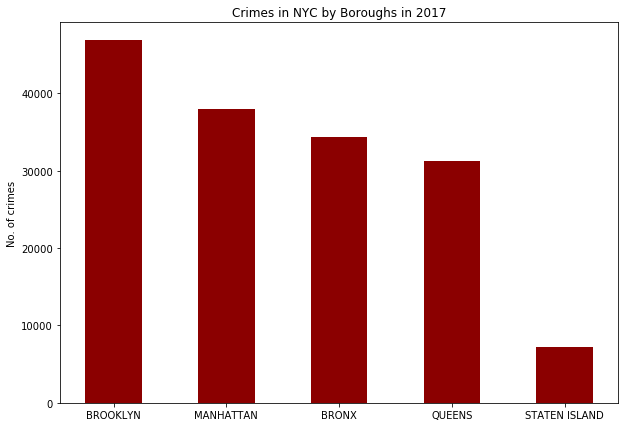

In [54]:
fig = plt.figure(figsize = (10, 7)) 
plt.bar(df2.index, df2["BORO_NM"], color='darkred', width=0.5)
plt.ylabel('No. of crimes')
plt.title('Crimes in NYC by Boroughs in 2017')

So its clear from the graph that Staten Island as the lowest crimes reported in 2017 so it would be an ideal borough to move to.

---

#### Now lets import the data set with NY neighborhoods and location data 

In [38]:
df_n = pd.read_csv("NY_n.csv",index_col=1)
df_n.drop("Unnamed: 0", axis=1,inplace=True)
df_n.head()

,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,Wakefield,40.894705,-73.847201
Bronx,Co-op City,40.874294,-73.829939
Bronx,Eastchester,40.887556,-73.827806
Bronx,Fieldston,40.895437,-73.905643
Bronx,Riverdale,40.890834,-73.912585


In [67]:
df_n.index.unique()

Index(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'], dtype='object', name='Borough')

In [68]:
df_staten =  df_n.loc[["Staten Island"],:].reset_index()
df_staten.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


In [69]:
df_staten.shape

(63, 4)

We can see from this that there are only 63 Neighborhoods in Staten Island giving us very few options to choose from for our ideal neighborhood 

So lets select the 3 borough with lowest crime, that is Bronx, Queens and Staten Island

In [123]:
df_n2 = df_n.loc[["Bronx", "Queens","Staten Island"],:].reset_index()
df_n2.columns = ["Borough", "Neighborhood", "Latitude", "Longitude"]
df_n2.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [71]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_n2['Borough'].unique()),
        df_n2.shape[0]
    )
)

The dataframe has 3 boroughs and 196 neighborhoods.


In [61]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a Map of NYC with these neighborhoods superimposed on top

In [72]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_n2['Latitude'], df_n2['Longitude'], df_n2['Borough'], df_n2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

---

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [94]:
CLIENT_ID = 'J5AKA3EMRLZ1NEQXXNCNHGGSAB2NHQE11G3SSMGO5RRM15QE' # your Foursquare ID
CLIENT_SECRET = '0DVGCB5ITNP0FX5ZWW2PXVQAGEE1UPL1ZD0TMAYK1WKV11UU' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J5AKA3EMRLZ1NEQXXNCNHGGSAB2NHQE11G3SSMGO5RRM15QE
CLIENT_SECRET:0DVGCB5ITNP0FX5ZWW2PXVQAGEE1UPL1ZD0TMAYK1WKV11UU


#### Let's create a function to repeat the process to get venues from the neighborhoods

In [95]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [98]:
venues = getNearbyVenues(names=df_n2['Neighborhood'],
                                   latitudes=df_n2['Latitude'],
                                   longitudes=df_n2['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights
Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Cente

#### Lets look at the new Dataframe

In [99]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


#### Lets see how many Venues have been returned for each Neighborhood

In [101]:
venues['Neighborhood'].value_counts()

Sunnyside Gardens    100
Astoria              100
Belmont               96
Fordham               83
Woodside              78
                    ... 
Malba                  2
Grymes Hill            1
Bayswater              1
Howland Hook           1
Todt Hill              1
Name: Neighborhood, Length: 194, dtype: int64

#### Let's find out how many unique categories can be curated from all the returned venues

In [102]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 326 uniques categories.


#### Lets do onehot encoding for each neighborhood

In [104]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waste Facility,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [106]:
venues_grouped = onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waste Facility,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Willowbrook,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190,Woodhaven,0.0,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191,Woodlawn,0.0,0.0,0.0,0.0,0.037037,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,Woodrow,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


First, let's write a function to sort the venues in descending order.

In [110]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [135]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Rental Car Location,Check Cashing Service,Gas Station,Breakfast Spot,Dessert Shop,Spanish Restaurant,Spa
1,Annadale,Pizza Place,Sports Bar,Park,Pharmacy,Diner,Restaurant,Train Station,Women's Store,Filipino Restaurant,Farm
2,Arden Heights,Deli / Bodega,Bus Stop,Pizza Place,Coffee Shop,Pharmacy,Food Court,Field,Falafel Restaurant,Farm,French Restaurant
3,Arlington,Bus Stop,Deli / Bodega,American Restaurant,Grocery Store,Boat or Ferry,Intersection,French Restaurant,Flea Market,Fast Food Restaurant,Field
4,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Pharmacy,Supermarket,Mediterranean Restaurant,Food Truck,Sandwich Place,Outdoors & Recreation,Liquor Store


### Lets Cluster Neighborhoods

First lets use the elbow method to figure out best no of *k* for Kmeans.


In [119]:
check_df = venues_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(check_df)
    distortions.append(kmeanModel.inertia_)

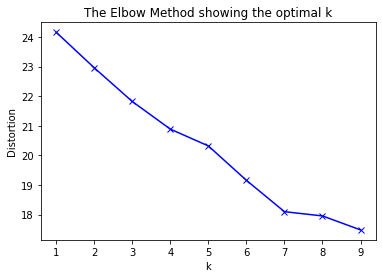

In [120]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

So the optimal value of k is 8 

In [121]:
# set number of clusters
kclusters = 8

grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([7, 7, 6, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [136]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df_n2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,7,Pharmacy,Food,Dessert Shop,Gas Station,Ice Cream Shop,Laundromat,Donut Shop,Sandwich Place,Flea Market,Farmers Market
1,Bronx,Co-op City,40.874294,-73.829939,7,Fast Food Restaurant,Deli / Bodega,Trail,Bus Station,Supermarket,Grocery Store,Park,Pharmacy,Bagel Shop,Pizza Place
2,Bronx,Eastchester,40.887556,-73.827806,1,Caribbean Restaurant,Bus Station,Diner,Deli / Bodega,Bowling Alley,Metro Station,Seafood Restaurant,Pizza Place,Platform,Fast Food Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,1,River,Bus Station,Business Service,Plaza,Women's Store,Flea Market,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,1,Bus Station,Park,Baseball Field,Bank,Gym,Home Service,Plaza,Fish & Chips Shop,Farmers Market,Fast Food Restaurant


Lets visualize the clusters

In [137]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Lets Examine Each cluster

#### Cluster 1

In [138]:
df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
157,Park Hill,Bus Stop,Coffee Shop,Gym / Fitness Center,Athletics & Sports,Hotel,Women's Store,Fish Market,Fast Food Restaurant,Field,Filipino Restaurant
160,Arlington,Bus Stop,Deli / Bodega,American Restaurant,Grocery Store,Boat or Ferry,Intersection,French Restaurant,Flea Market,Fast Food Restaurant,Field
177,Chelsea,Bus Stop,Steakhouse,Park,Spanish Restaurant,Sandwich Place,Fish Market,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
178,Bloomfield,Recreation Center,Burger Joint,Bus Stop,Theme Park,French Restaurant,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Field
185,Randall Manor,Deli / Bodega,Home Service,Bus Stop,Business Service,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
189,Willowbrook,Bus Stop,Chinese Restaurant,Deli / Bodega,Intersection,Pizza Place,Spa,Fish Market,Farm,Farmers Market,Fast Food Restaurant
195,Fox Hills,Bus Stop,Sandwich Place,Women's Store,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market


#### Cluster 2

We can see that in this cluster the most common venue is Bus Stop, so if someone wants to move to a neighborhood with a bus stop nearby then can choose neighborhood from this cluster

In [139]:
df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Eastchester,Caribbean Restaurant,Bus Station,Diner,Deli / Bodega,Bowling Alley,Metro Station,Seafood Restaurant,Pizza Place,Platform,Fast Food Restaurant
3,Fieldston,River,Bus Station,Business Service,Plaza,Women's Store,Flea Market,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
4,Riverdale,Bus Station,Park,Baseball Field,Bank,Gym,Home Service,Plaza,Fish & Chips Shop,Farmers Market,Fast Food Restaurant
8,Williamsbridge,Nightclub,Bar,Caribbean Restaurant,Soup Place,Flea Market,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
9,Baychester,Donut Shop,Fried Chicken Joint,Pizza Place,Men's Store,Shopping Mall,Mattress Store,Spanish Restaurant,Pet Store,Bank,Sandwich Place
...,...,...,...,...,...,...,...,...,...,...,...
188,Manor Heights,Donut Shop,Deli / Bodega,Liquor Store,Pharmacy,Home Service,Bagel Shop,Campground,Sushi Restaurant,Chinese Restaurant,American Restaurant
190,Sandy Ground,Clothing Store,Intersection,Food Truck,Racetrack,Bus Stop,Art Gallery,Greek Restaurant,Playground,Fish & Chips Shop,Fish Market
191,Egbertville,Italian Restaurant,Clothing Store,Cosmetics Shop,Bagel Shop,Flea Market,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
193,Lighthouse Hill,Massage Studio,Trail,Italian Restaurant,Spa,Art Museum,Café,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


#### Cluster 3

In [140]:
df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
115,Somerville,Park,Business Service,Women's Store,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market
139,Todt Hill,Park,Women's Store,Furniture / Home Store,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market
143,Port Ivory,Bar,Business Service,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market


#### Cluster 4

In [141]:
df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,Breezy Point,Beach,Monument / Landmark,Bus Stop,Trail,Women's Store,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
102,Neponsit,Beach,Beach Bar,Women's Store,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market
130,Hammels,Beach,Deli / Bodega,Bus Stop,Fast Food Restaurant,Gym / Fitness Center,Dog Run,Shoe Store,Bus Station,Food Truck,Diner
140,South Beach,Deli / Bodega,Beach,Pier,Bus Stop,Athletics & Sports,Flea Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
186,Howland Hook,Pier,Women's Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market


#### Cluster 5

In [142]:
df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
138,Grymes Hill,Dog Run,Women's Store,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market


#### Cluster 6

In [143]:
df_merged.loc[df_merged['Cluster Labels'] == 5, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
131,Bayswater,Playground,Women's Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market


#### Cluster 7

In [144]:
df_merged.loc[df_merged['Cluster Labels'] == 6, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Morris Heights,Deli / Bodega,Pizza Place,Recreation Center,Spanish Restaurant,Check Cashing Service,Bus Station,Grocery Store,Supermarket,Food,Bank
31,Van Nest,Deli / Bodega,Pizza Place,Spa,Playground,BBQ Joint,Supermarket,Coffee Shop,Hookah Bar,Board Shop,Spanish Restaurant
44,Edenwald,Playground,Deli / Bodega,Supermarket,Grocery Store,Flea Market,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
67,Glendale,Brewery,Arts & Crafts Store,Pizza Place,Food & Drink Shop,Deli / Bodega,Indonesian Restaurant,Flea Market,Farm,Farmers Market,Fast Food Restaurant
73,Whitestone,Dance Studio,Deli / Bodega,Candy Store,Bubble Tea Shop,Diner,Fast Food Restaurant,Filipino Restaurant,Dessert Shop,Fish & Chips Shop,Fish Market
82,Briarwood,Deli / Bodega,Sushi Restaurant,Plaza,Bus Station,Convenience Store,Coffee Shop,Arts & Crafts Store,Playground,Fast Food Restaurant,Field
94,Broad Channel,Sporting Goods Shop,Deli / Bodega,Dive Bar,Pizza Place,Other Nightlife,Women's Store,Flea Market,Fast Food Restaurant,Field,Filipino Restaurant
116,Brookville,Deli / Bodega,Recording Studio,Food,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market
118,North Corona,Deli / Bodega,Pizza Place,Bakery,Gym / Fitness Center,South American Restaurant,Mexican Restaurant,Museum,Hotel Bar,Hotel,Latin American Restaurant
121,Utopia,Deli / Bodega,Donut Shop,Spa,South American Restaurant,Pizza Place,History Museum,Bakery,Playground,Automotive Shop,Basketball Court


#### Cluster 8

In [145]:
df_merged.loc[df_merged['Cluster Labels'] == 7, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Pharmacy,Food,Dessert Shop,Gas Station,Ice Cream Shop,Laundromat,Donut Shop,Sandwich Place,Flea Market,Farmers Market
1,Co-op City,Fast Food Restaurant,Deli / Bodega,Trail,Bus Station,Supermarket,Grocery Store,Park,Pharmacy,Bagel Shop,Pizza Place
5,Kingsbridge,Pizza Place,Bar,Sandwich Place,Mexican Restaurant,Supermarket,Donut Shop,Latin American Restaurant,Spanish Restaurant,Pharmacy,Bakery
6,Woodlawn,Pizza Place,Food & Drink Shop,Deli / Bodega,Pub,Playground,Laundromat,Donut Shop,Park,Food Truck,Grocery Store
7,Norwood,Pizza Place,Park,Chinese Restaurant,Bank,Pharmacy,Deli / Bodega,Coffee Shop,Bus Station,Supermarket,Mobile Phone Shop
...,...,...,...,...,...,...,...,...,...,...,...
175,Greenridge,Pet Store,Shipping Store,Diner,Professional & Other Places,Construction & Landscaping,Spa,Bagel Shop,Lawyer,Pizza Place,Fish & Chips Shop
176,Heartland Village,Coffee Shop,Pharmacy,Food Truck,Restaurant,Spa,Pizza Place,Donut Shop,Fish & Chips Shop,Farm,Farmers Market
179,Bulls Head,Bus Stop,Pizza Place,Ice Cream Shop,Gift Shop,Deli / Bodega,Pharmacy,Sandwich Place,Chinese Restaurant,Food Truck,Liquor Store
182,Clifton,Pizza Place,Train Station,Mexican Restaurant,Grocery Store,Intersection,Martial Arts Dojo,Deli / Bodega,Discount Store,Eastern European Restaurant,Park


So we can clearly see that each clusters have a different most common venue, likes cluster 4 has beach as the most common venue. So if someone wants to move to a neighborhood with a beach nearby they can choose any neighborhood from cluster 4. Similarly a decision can be made based on other clusters and venues.